Running ICM for 5 random seed nodes:
Seed Node: 16969, Steps: 4, Infected Nodes: 5
Seed Node: 28077, Steps: 3, Infected Nodes: 3
Seed Node: 60428, Steps: 2, Infected Nodes: 2
Seed Node: 10705, Steps: 3, Infected Nodes: 3
Seed Node: 27898, Steps: 8, Infected Nodes: 13

Average number of steps over 5 runs: 4.00


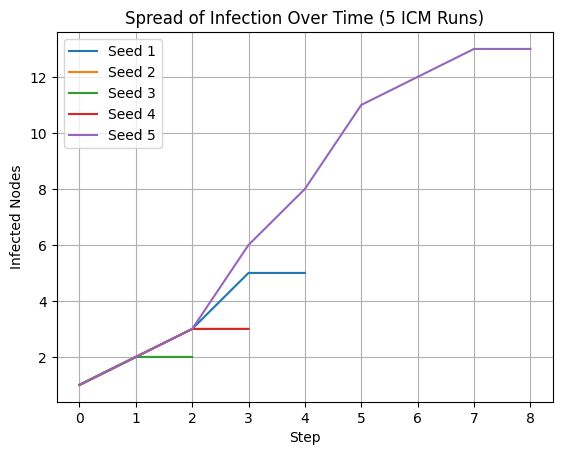

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

# Load the graph from sample.txt, ignoring the timestamp column
G = nx.DiGraph()
with open("/content/sx-mathoverflow.txt", "r") as f:
    for line in f:
        u, v, _ = line.strip().split()
        G.add_edge(int(u), int(v))

# Assign normalized random activation probabilities for each node's outgoing edges
activation_prob = {}
for node in G.nodes():
    neighbors = list(G.successors(node))
    if neighbors:
        probs = np.random.rand(len(neighbors))
        probs /= probs.sum()  # Normalize to sum = 1
        activation_prob[node] = dict(zip(neighbors, probs))
    else:
        activation_prob[node] = {}

# New version of independent_cascade to return full timeline
def independent_cascade_timeline(G, seed, activation_prob):
    active = set([seed])
    newly_active = set([seed])
    steps = 0
    timeline = [1]  # Start with just the seed

    while newly_active:
        next_newly_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = activation_prob.get(node, {}).get(neighbor, 0)
                    if random.random() <= prob:
                        next_newly_active.add(neighbor)
        newly_active = next_newly_active
        active.update(newly_active)
        steps += 1
        timeline.append(len(active))

    return steps, len(active), timeline

# Run 5 random seed experiments and collect timelines
random_seeds = random.sample(list(G.nodes()), 5)
all_timelines = []
step_results = []

print("Running ICM for 5 random seed nodes:")
for seed in random_seeds:
    steps, total_infected, timeline = independent_cascade_timeline(G, seed, activation_prob)
    print(f"Seed Node: {seed}, Steps: {steps}, Infected Nodes: {total_infected}")
    all_timelines.append(timeline)
    step_results.append(steps)

avg_steps = sum(step_results) / len(step_results)
print(f"\nAverage number of steps over 5 runs: {avg_steps:.2f}")

# Plot all 5 timelines
for idx, timeline in enumerate(all_timelines):
    plt.plot(range(len(timeline)), timeline, label=f"Seed {idx+1}")

plt.title("Spread of Infection Over Time (5 ICM Runs)")
plt.xlabel("Step")
plt.ylabel("Infected Nodes")
plt.legend()
plt.grid(True)
plt.show()


Running ICM from all nodes (this might take a minute)...


100%|██████████| 24818/24818 [00:08<00:00, 3030.27it/s]


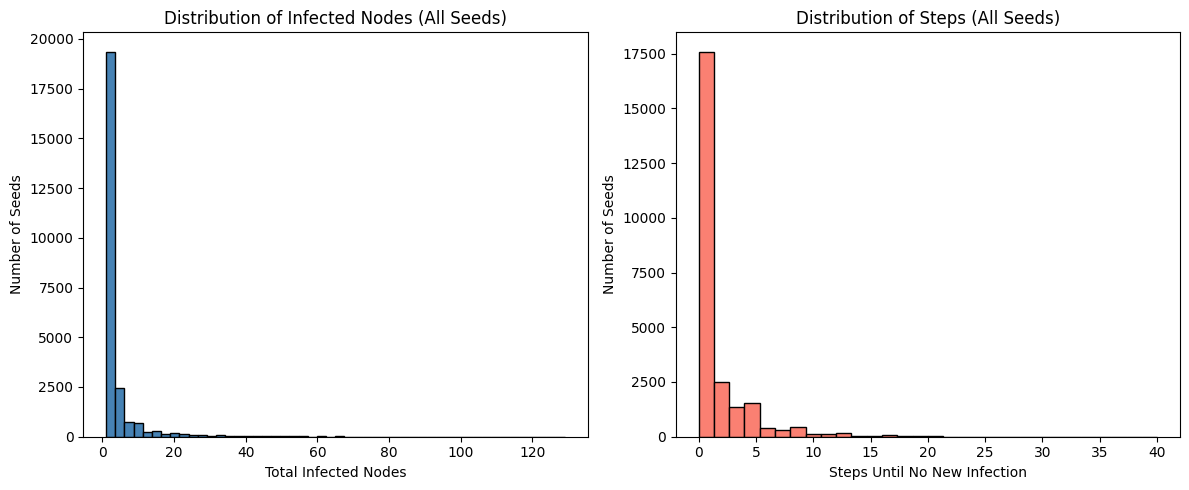


Top 10 most influential seed nodes:
Node 9468: infected 129 nodes
Node 12914: infected 128 nodes
Node 58719: infected 128 nodes
Node 968: infected 124 nodes
Node 966: infected 120 nodes
Node 13923: infected 119 nodes
Node 11638: infected 118 nodes
Node 56099: infected 117 nodes
Node 4672: infected 116 nodes
Node 4017: infected 111 nodes


In [19]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm  # progress bar for large graphs

# Load graph
G = nx.DiGraph()
with open("/content/sx-mathoverflow.txt", "r") as f:
    for line in f:
        u, v, _ = line.strip().split()
        G.add_edge(int(u), int(v))

# Assign normalized random activation probabilities per outgoing edges
activation_prob = {}
for node in G.nodes():
    neighbors = list(G.successors(node))
    if neighbors:
        probs = np.random.rand(len(neighbors))
        probs /= probs.sum()
        activation_prob[node] = dict(zip(neighbors, probs))
    else:
        activation_prob[node] = {}

# ICM function with timeline
def independent_cascade(G, seed, activation_prob):
    active = set([seed])
    newly_active = set([seed])
    steps = 0

    while newly_active:
        next_newly_active = set()
        for node in newly_active:
            for neighbor in G.successors(node):
                if neighbor not in active:
                    prob = activation_prob.get(node, {}).get(neighbor, 0)
                    if random.random() <= prob:
                        next_newly_active.add(neighbor)
        newly_active = next_newly_active
        active.update(newly_active)
        steps += 1 if newly_active else 0

    return steps, len(active)

# Run ICM for all nodes
all_steps = []
all_infected = []

print("Running ICM from all nodes (this might take a minute)...")
for node in tqdm(G.nodes()):
    steps, infected = independent_cascade(G, node, activation_prob)
    all_steps.append(steps)
    all_infected.append(infected)

# Plot: histogram of total infected nodes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_infected, bins=50, color='steelblue', edgecolor='black')
plt.title("Distribution of Infected Nodes (All Seeds)")
plt.xlabel("Total Infected Nodes")
plt.ylabel("Number of Seeds")

# Plot: histogram of steps
plt.subplot(1, 2, 2)
plt.hist(all_steps, bins=30, color='salmon', edgecolor='black')
plt.title("Distribution of Steps (All Seeds)")
plt.xlabel("Steps Until No New Infection")
plt.ylabel("Number of Seeds")

plt.tight_layout()
plt.show()

# Optional: show top spreaders
top_spreaders = sorted(zip(G.nodes(), all_infected), key=lambda x: -x[1])[:10]
print("\nTop 10 most influential seed nodes:")
for node, infected in top_spreaders:
    print(f"Node {node}: infected {infected} nodes")
